In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv


In [2]:
# LOAD THE DATA
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

Importing libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

Preprocessing Data

In [4]:
# PREPARE DATA FOR NEURAL NETWORK
X_train = train.drop(labels = ["label"],axis = 1)
Y_train = train["label"]
# Normalize pixels
X_train = X_train / 255.0
X_test = test / 255.0

In [5]:
X_train.shape

(42000, 784)

In [6]:
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)
# This will convert digits into flag array of size 10

In [7]:
X_train.shape

(42000, 28, 28, 1)

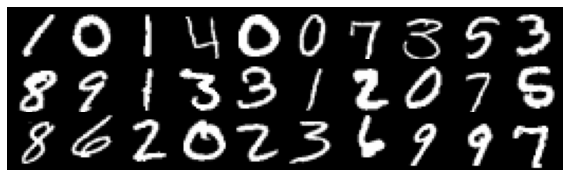

In [8]:
import matplotlib.pyplot as plt
# Plotting mnist images
plt.figure(figsize=(10,3))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.gray)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

Let's Create some more data
# DATA AUGMENTATION

In [9]:
datagenerated = ImageDataGenerator(
        rotation_range=14,  
        zoom_range = 0.1,
        channel_shift_range=0.4,
        width_shift_range=0.13, 
        height_shift_range=0.13)

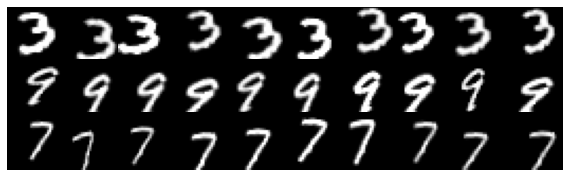

In [10]:
# Taking 1 element from train dataset
X_train3 = X_train[9,].reshape((1,28,28,1))
Y_train3 = Y_train[9,].reshape((1,10))
plt.figure(figsize=(10,3))
# Applying the filter
for i in range(30):  
    plt.subplot(3, 10, i+1)
    X_train2, Y_train2 = datagenerated.flow(X_train3,Y_train3).next()
    plt.imshow(X_train2[0].reshape((28,28)),cmap=plt.cm.gray)
    plt.axis('off')
    if i==9: X_train3 = X_train[11,].reshape((1,28,28,1))
    if i==19: X_train3 = X_train[18,].reshape((1,28,28,1))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [11]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
layers = 15
#Taking default [32, 64, 128] conv2d filter
model = Sequential()

model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size = 4, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

# COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
model.compile(optimizer="RMSprop", loss="categorical_crossentropy", metrics=["accuracy"])

Our model looks like this now:

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0

import tensorflow as tf 

if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Check cuda avaialable or not:

In [13]:
import time
import glob
import torch
import os

from IPython.display import Image, clear_output 
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.1 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [14]:
# DECREASE LEARNING RATE EACH EPOCH
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.951 ** x)
# TRAIN NETWORKS
History = None
epochs = 40
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.1)
History = model.fit(datagenerated.flow(X_train2,Y_train2, batch_size=64),
                                    epochs = epochs, steps_per_epoch = X_train2.shape[0]//128,
                                    validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=1)

Epoch 1/40
295/295 [==============================] - 10s 35ms/step - loss: 0.9598 - accuracy: 0.7047 - val_loss: 0.7892 - val_accuracy: 0.7781 - lr: 0.0010
Epoch 2/40
295/295 [==============================] - 10s 35ms/step - loss: 0.2426 - accuracy: 0.9271 - val_loss: 0.1698 - val_accuracy: 0.9464 - lr: 9.5100e-04
Epoch 3/40
295/295 [==============================] - 10s 35ms/step - loss: 0.1719 - accuracy: 0.9472 - val_loss: 0.0509 - val_accuracy: 0.9855 - lr: 9.0440e-04
Epoch 4/40
295/295 [==============================] - 10s 34ms/step - loss: 0.1366 - accuracy: 0.9590 - val_loss: 0.0534 - val_accuracy: 0.9850 - lr: 8.6009e-04
Epoch 5/40
295/295 [==============================] - 11s 38ms/step - loss: 0.1149 - accuracy: 0.9667 - val_loss: 0.0373 - val_accuracy: 0.9883 - lr: 8.1794e-04
Epoch 6/40
295/295 [==============================] - 10s 36ms/step - loss: 0.1015 - accuracy: 0.9702 - val_loss: 0.0389 - val_accuracy: 0.9883 - lr: 7.7786e-04
Epoch 7/40
295/295 [==================

In [15]:
print("Final train_data accuracy:",History.history['accuracy'][-1])
print("Final val_data accuracy:",History.history['val_accuracy'][-1])


Final train_data accuracy: 0.9916843175888062
Final val_data accuracy: 0.993571400642395


In [16]:
# ENSEMBLE PREDICTIONS AND SUBMIT
results = np.zeros( (X_test.shape[0],10) ) 
results = results + model.predict(X_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("MNIST-LeNet.csv",index=False)

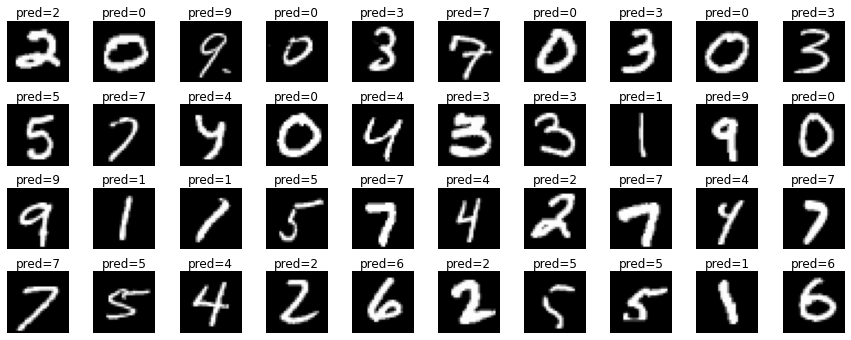

In [17]:
# PREVIEW PREDICTIONS
plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(X_test[i].reshape((28,28)),cmap=plt.cm.gray)
    plt.title("pred=%d" % results[i],y=0.9 ,pad=10)
    plt.axis('off')
plt.subplots_adjust(wspace=0.4, hspace=0.1)
plt.show()

Let's save our model in a zip file
(I want to use it later)

In [18]:
model.save('model_data')

In [19]:
import os
import zipfile

zf = zipfile.ZipFile("model_data.zip", "w")
for dirname, subdirs, files in os.walk("model_data"):
    zf.write(dirname)
    for filename in files:
        zf.write(os.path.join(dirname, filename))
zf.close()